In [ ]:
!pip install snntorch --quiet
!pip install tonic --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.8 MB/s eta 0:00:00


In [ ]:
#imports
import tonic
import matplotlib.pyplot as plt
import tonic.transforms as transforms

import snntorch as snn
from snntorch import utils
from snntorch import surrogate
from snntorch import functional as SF

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import itertools
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

#1. The Dataset - POKERDVS
The dataset used in this tutorial is POKERDVS by T. Serrano-Gotarredona and B. Linares-Barranco.

It is comprised of 4 classes, each being a suite of a playing card deck. (clubs, spades, hearts, and diamonds)

The data consists of 131 poker pip symbols, and was collected by flipping poker cards in front of a DVS128 camera.


#1.1 Loading the Dataset and Transforming it with Tonic
The dataset presents data in a raw event format, so it must be shaped into a suitable format that can be fed into a model.

The following code bins the raw DVS event data into 2000ms time windows, allowing the resulting tensors to be preprocessed before being put into the DataLoader.

In [ ]:
sensor_size = tonic.datasets.POKERDVS.sensor_size
# converting 2000 ms blocks of data into frames
frame_transform = transforms.ToFrame(sensor_size=sensor_size, time_window=2000)

poker_train = tonic.datasets.POKERDVS(save_to = './data', train = True, transform = frame_transform)
poker_test = tonic.datasets.POKERDVS(save_to = './data', train = False, transform = frame_transform)

  0%|          | 0/700096 [00:00<?, ?it/s]

Extracting ./data/POKERDVS/pips_train.tar.gz to ./data/POKERDVS


  0%|          | 0/311022 [00:00<?, ?it/s]

Extracting ./data/POKERDVS/pips_test.tar.gz to ./data/POKERDVS


#1.2 Visualizing the Data
We can use pyplot to vizualize each of the frames being passed into the dataloader.

As seen below, outlines of poker symbols are visible in each frame.

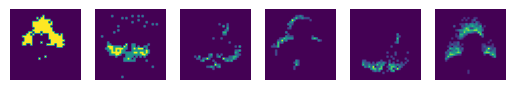

In [ ]:
fig, ax = plt.subplots(1, 6)
data, targets = poker_train[0]
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')
ax[5].axis('off')
ax[0].imshow(data[0][0])
ax[1].imshow(data[0][1])
ax[2].imshow(data[3][0])
ax[3].imshow(data[3][1])
ax[4].imshow(data[5][0])
ax[5].imshow(data[5][1])

#1.3 Caching and Loading the Dataset
A dataloader can be used to prepare our data for training by separating it into batches and shuffling it. We can also use caching to speed up the dataloading process by reading data from cache rather than the disk.

In [ ]:
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(poker_train, cache_path='./cache/dvspoker/train')
cached_testset = DiskCachedDataset(poker_test, cache_path='./cache/dvspoker/test')

In [ ]:
#Set a mini-batch size of 8, for a total of 6 training batches
batch_size = 8
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [ ]:
print(len(trainloader))

6


#2. The Model

#2.1 Defining the Network
The model used is a sequential network comprised of two sets of convolution layers with 5x5 filters, followed by a final linear and leaky output layer that convert the 800 tensor into 4 output classes.

The forward function gets the spikes from one batch of data and returns them as a tensor.

In [ ]:
#parameters
num_classes = 4
spike_grad = surrogate.atan() # arctan surrogate gradient function
beta = 0.5

net = nn.Sequential(nn.Conv2d(2, 12, 5), # first conv layer
                        snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                        nn.MaxPool2d(2),
                        nn.Conv2d(12, 32, 5), # second conv layer
                        snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(32*5*5, num_classes), #flattened linear layer
                        snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                        ).to(device)

def forward(net, data):  # define forward function
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net
  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
  return torch.stack(spk_rec)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.003, betas=(0.9, 0.999)) # learning rate = 0.003
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2) # MSE loss function

#2.2 Training
We will be training our network for 20 epochs, and 6 iterations, since there are 8 batches and 48 total training examples.

In [ ]:
num_epochs = 20
num_iters = 6

loss_hist = []
acc_hist = []
test_acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        correct = 0
        total = 0
        for i, (test_data, test_targets) in enumerate(iter(testloader)):
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)
            spk_rec = forward(net, test_data)
            correct += SF.accuracy_rate(spk_rec, test_targets) * spk_rec.size(1)
            total += spk_rec.size(1)

        test_acc = (correct/total) * 100
        test_acc_hist.append(test_acc)
        print(f"========== Test Set Accuracy: {test_acc:.2f}% ==========\n")
        # This will end training after 6 iterations by default
        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 2.37
Accuracy: 12.50%

========== Test Set Accuracy: 25.00% ==========

Epoch 0, Iteration 1 
Train Loss: 1.86
Accuracy: 12.50%

========== Test Set Accuracy: 40.00% ==========

Epoch 0, Iteration 2 
Train Loss: 1.08
Accuracy: 25.00%

========== Test Set Accuracy: 25.00% ==========

Epoch 0, Iteration 3 
Train Loss: 0.65
Accuracy: 12.50%

========== Test Set Accuracy: 30.00% ==========

Epoch 0, Iteration 4 
Train Loss: 0.78
Accuracy: 37.50%

========== Test Set Accuracy: 35.00% ==========

Epoch 0, Iteration 5 
Train Loss: 1.09
Accuracy: 50.00%

========== Test Set Accuracy: 25.00% ==========

Epoch 1, Iteration 0 
Train Loss: 1.01
Accuracy: 25.00%

========== Test Set Accuracy: 20.00% ==========

Epoch 1, Iteration 1 
Train Loss: 1.03
Accuracy: 37.50%

========== Test Set Accuracy: 35.00% ==========

Epoch 1, Iteration 2 
Train Loss: 1.23
Accuracy: 0.00%

========== Test Set Accuracy: 35.00% ==========

Epoch 1, Iteration 3 
Train Loss: 0.79
Accuracy

#3. Results

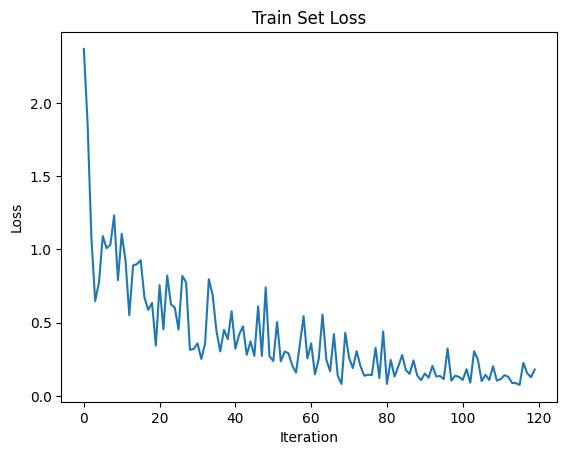

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(loss_hist)
plt.title("Train Set Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

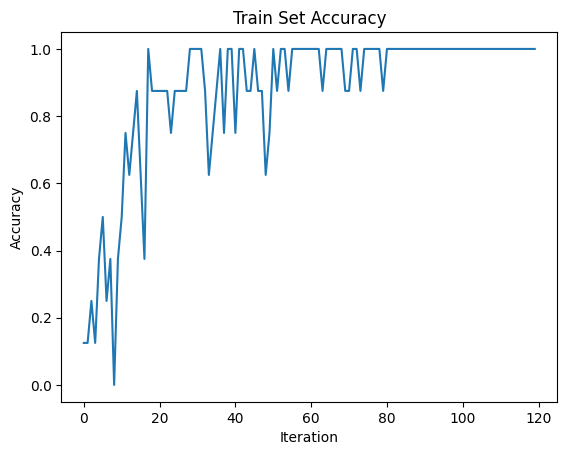

In [ ]:
# Plot Train Accuracy
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

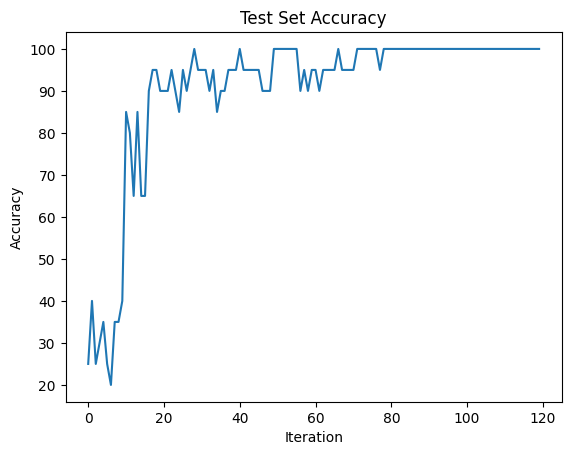

In [ ]:
# Plot Test Accuracy
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()